<a href="https://www.kaggle.com/code/drmclandgraf/ps5e10-predicting-road-accident-risk?scriptVersionId=271538714" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<h1>Predicting Road Accident Risk</h1> 

Welcome to my notebook for this playground challenge. I will try to... 
- Make some initial data exploration 
- Exploring datatypes and distribution 
- Exploring connections between the variables
- Train a suitable model
- Explore, which variables make the most impact

<h3>Initial Setup</h3> 

In [1]:
# This is the standard code, when creating a new notebook on Kaggle with some extra libraries loaded

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e10/sample_submission.csv
/kaggle/input/playground-series-s5e10/train.csv
/kaggle/input/playground-series-s5e10/test.csv


At first, we load the train and test data.
To get a first look at the data, we print the first few rows.

In [2]:
train = pd.read_csv("/kaggle/input/playground-series-s5e10/train.csv")
test_submission = pd.read_csv("/kaggle/input/playground-series-s5e10/test.csv")
train.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


<h3>First look at the data</h3> 
We can already see, that we have different types of data. "road_type" is categorical, "num_lanes" is numerical, and "road_signs_present" is boolean.
We further can already guess, that our numerical data is on different scales.
"num_lanes" describing the number of lanes can only have discreet values, starting at 1. It will also probably have a rather small upper limit. The speed limit also only has certain predefined values, while curvature only can be a number between 0 and 1. <br>
We can also look print the different types of data we have in our dataset.

In [3]:
train.dtypes

id                          int64
road_type                  object
num_lanes                   int64
curvature                 float64
speed_limit                 int64
lighting                   object
weather                    object
road_signs_present           bool
public_road                  bool
time_of_day                object
holiday                      bool
school_season                bool
num_reported_accidents      int64
accident_risk             float64
dtype: object

Again, we can see our different datatypes, we have numerical (int64 and float64; float64 can have decimals), categorical (object) and boolian (bool; meaning True or False are possible values). 
<br>
Lets take a look at how the data is distributed, at first the numerical values.

In [4]:
train.describe()

,id,num_lanes,curvature,speed_limit,num_reported_accidents,accident_risk
count,517754.000000,517754.000000,517754.000000,517754.000000,517754.000000,517754.000000
mean,258876.500000,2.491511,0.488719,46.112575,1.187970,0.352377
std,149462.849974,1.120434,0.272563,15.788521,0.895961,0.166417
min,0.000000,1.000000,0.000000,25.000000,0.000000,0.000000
25%,129438.250000,1.000000,0.260000,35.000000,1.000000,0.230000
50%,258876.500000,2.000000,0.510000,45.000000,1.000000,0.340000
75%,388314.750000,3.000000,0.710000,60.000000,2.000000,0.460000
max,517753.000000,4.000000,1.000000,70.000000,7.000000,1.000000


Again, we see curvature and accident_risk are between 0 and 1. There are up to 4 lanes, and the speed limit can be between 25 and 70mph. <br>
The number of reported accidents range from 0 to 7. <br>
Now lets look at our categorical data. As "num_lanes", "speed_limit", "num_reported_accidents" only can take on discreet values, we again look at how they are distributed.

In [5]:
for column in train.select_dtypes(include=['object', "boolean"]).columns:
    display(train[column].value_counts())

display(train["num_lanes"].value_counts())
display(train["speed_limit"].value_counts())
display(train["num_reported_accidents"].value_counts())

road_type
highway    173672
rural      172719
urban      171363
Name: count, dtype: int64

lighting
dim         183826
daylight    178015
night       155913
Name: count, dtype: int64

weather
foggy    181463
clear    179306
rainy    156985
Name: count, dtype: int64

road_signs_present
False    259289
True     258465
Name: count, dtype: int64

public_road
True     260045
False    257709
Name: count, dtype: int64

time_of_day
morning      173410
evening      172837
afternoon    171507
Name: count, dtype: int64

holiday
True     260688
False    257066
Name: count, dtype: int64

school_season
False    260164
True     257590
Name: count, dtype: int64

num_lanes
1    131168
2    130054
4    129118
3    127414
Name: count, dtype: int64

speed_limit
45    115752
35    111628
25    101422
60    100304
70     88648
Name: count, dtype: int64

num_reported_accidents
1    209674
2    145965
0    125269
3     34197
4      2392
5       231
6        24
7         2
Name: count, dtype: int64

Most the categories are of roughly equal size. That's good! If some categories only had a few entries, most models would have a hard time learning this category and we might have to resort to stratified sampling or weighing the data. <br>
Speed_limit has a few less entries at speed limit of 70, but thats still plenty. <br>
For the number of reported accidents, there are only few places with 4 or more accidents. This might become a problem, depending on how we treat the variable. If we decide to treat it as categorical, we have only 2 examples for the last category. We could collapse some categories, for example all with 3 or more reported accidents. But we can also just treat this variable as if it would be numerical. <br>
Now lets take another look at the distribution of our two final numerical variables, curvature and accident risk, by plotting them.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


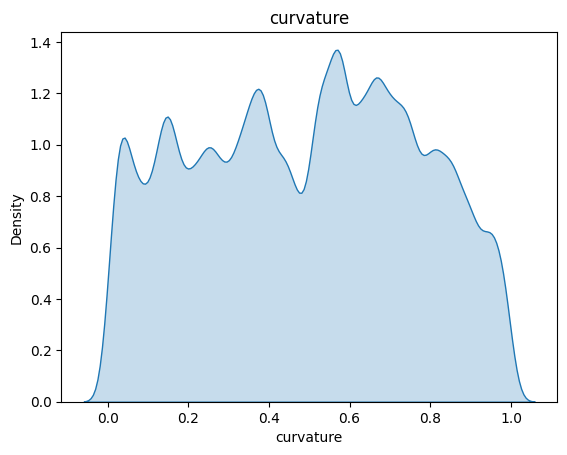

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


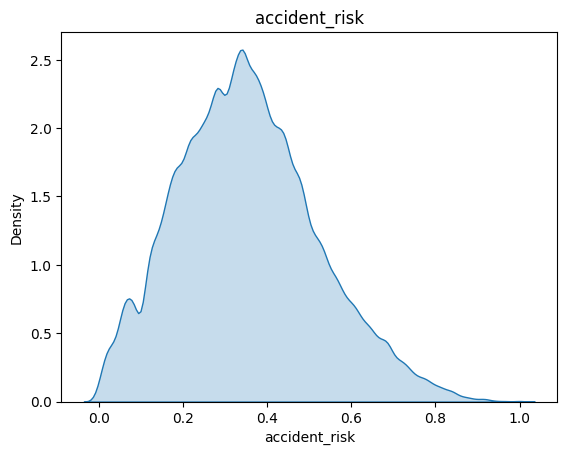

In [6]:
sns.kdeplot(x = train["curvature"], fill = True)
plt.title("curvature")
plt.show()
sns.kdeplot(x = train["accident_risk"], fill = True) 
plt.title("accident_risk")
plt.show()

We can see that both are not really normally distributed.
While this in itself is not a problem it could become one depending on how we choose to model the risk and how we include the curvature. <br>

<h3>Exploring Associations between Variables</h3> 

In the next step, we will look at how different variables are distributed in connection to each other. <br>
For this, we at first split the data into different sets, a training, a validation, and a test set (A different then the one we use for our submissions). I use the training set to train a model and tune hyperparameters, the validation set to explore the variables and compare different models and strategies, and the test set to estimate how well the final model performs. <br>
We split up the data before we look at how our dependent variable (accident risk) is connected to other variables to avoid data leakage. <br>

In [7]:
train = train.drop("id", axis = 1)
train, test = train_test_split(train, test_size = 0.2, random_state = 13)
train, val = train_test_split(train, test_size = 0.25, random_state = 13)
train.head()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
105747,rural,1,0.53,35,daylight,clear,False,True,evening,False,False,2,0.17
454325,rural,1,0.04,45,daylight,rainy,True,True,morning,True,True,2,0.14
426314,urban,4,0.25,70,daylight,clear,True,False,morning,False,False,1,0.37
249984,highway,1,0.39,35,daylight,rainy,True,True,morning,False,False,2,0.22
192101,urban,3,0.93,70,dim,foggy,True,True,evening,True,False,1,0.61


Now it is time to explore associations between the different variables. At first we might want to look at correlations.

<Axes: >

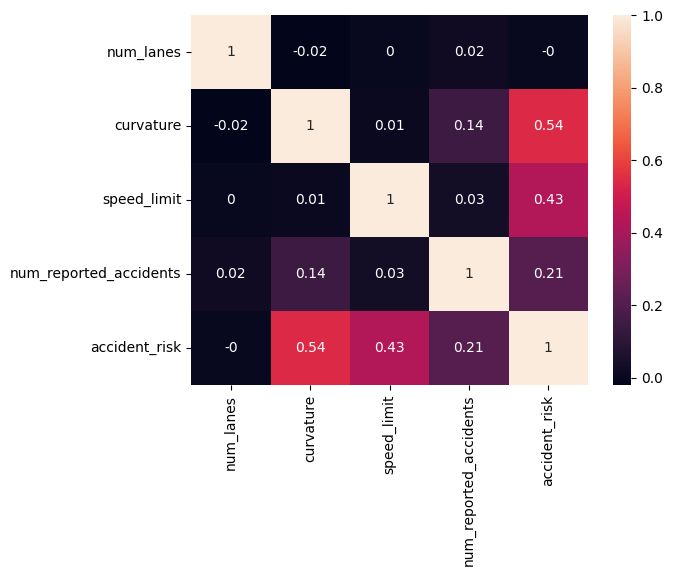

In [8]:
s = ((train.dtypes == "object") | (train.dtypes ==  "bool"))
object_cols = list(s[s].index)
sns.heatmap(train.drop(object_cols, axis =1).corr().round(2), annot = True)

We see a rather high correlation between curvature and accident_risk as well as speed_limit and accident risk, these seem like good predictors. <b>
We do, however, have quite a few categorical variables in our dataset, so we should examine these instead. For them, the correlation-coefficient does not make a lot of sense to use, but we can use different effect sizes, like the correlation ratio and Cramers V. <br>
Correlation ratios compares the sum of squares between groups and within groups, larger numbers meaning there is more variation between groups than within them. <br>
Cramers V shows the association between two nominal variables, with larger numbers meaning a higher association. <br>
We will calculate all these to get an estimation for where there are possible associations between variables, and between the predictorvariables and the outcome (accident risk).

In [9]:
import numpy as np
from scipy import stats
import itertools
# from https://towardsdatascience.com/a-definitive-guide-to-effect-size-9bc93f00db86/ by Eryk Lewinson
def get_cramer_v(x, y):
    n = len(x)
    cont_table = pd.crosstab(x, y)
    chi_2 = stats.chi2_contingency(cont_table, correction=False)[0]
    v = np.sqrt(chi_2 / (n * (np.min(cont_table.shape) - 1)))
    return v

#code from https://stackoverflow.com/questions/52083501/how-to-compute-correlation-ratio-or-eta-in-python by Kiryl
def correlation_ratio(categories, values):
    categories = np.array(categories)
    values = np.array(values)
    
    ssw = 0
    ssb = 0
    for category in set(categories):
        subgroup = values[np.where(categories == category)[0]]
        ssw += sum((subgroup-np.mean(subgroup))**2)
        ssb += len(subgroup)*(np.mean(subgroup)-np.mean(values))**2

    return (ssb / (ssb + ssw))**.5

def score_maker(data):
    cols_save = data.columns
    types = data.dtypes
    k = len(cols_save)
    res_df = pd.DataFrame([[None]*k for i in range(k)],cols_save, cols_save)
    for feature1 in cols_save:
        for feature2 in cols_save:
            if feature1 == feature2:
                res_df.loc[feature1, feature2] = 1
            elif types.loc[feature1] in ["int64", "float64"]:
                if types.loc[feature2] in ["int64", "float64"]:
                    res_df.loc[feature1, feature2] = train[[feature1, feature2]].corr().iloc[1,0]
                if types.loc[feature2] in ["bool", "object"]:
                    res_df.loc[feature1, feature2] = correlation_ratio(train[feature2], train[feature1])
            elif types.loc[feature1] in ["bool", "object"]:
                if types.loc[feature2] in ["int64", "float64"]:
                    res_df.loc[feature1, feature2] = correlation_ratio(train[feature1], train[feature2])
                if types.loc[feature2] in ["bool", "object"]:
                    res_df.loc[feature1, feature2] = get_cramer_v(train[feature2], train[feature1])
    return(res_df)
        

<Axes: >

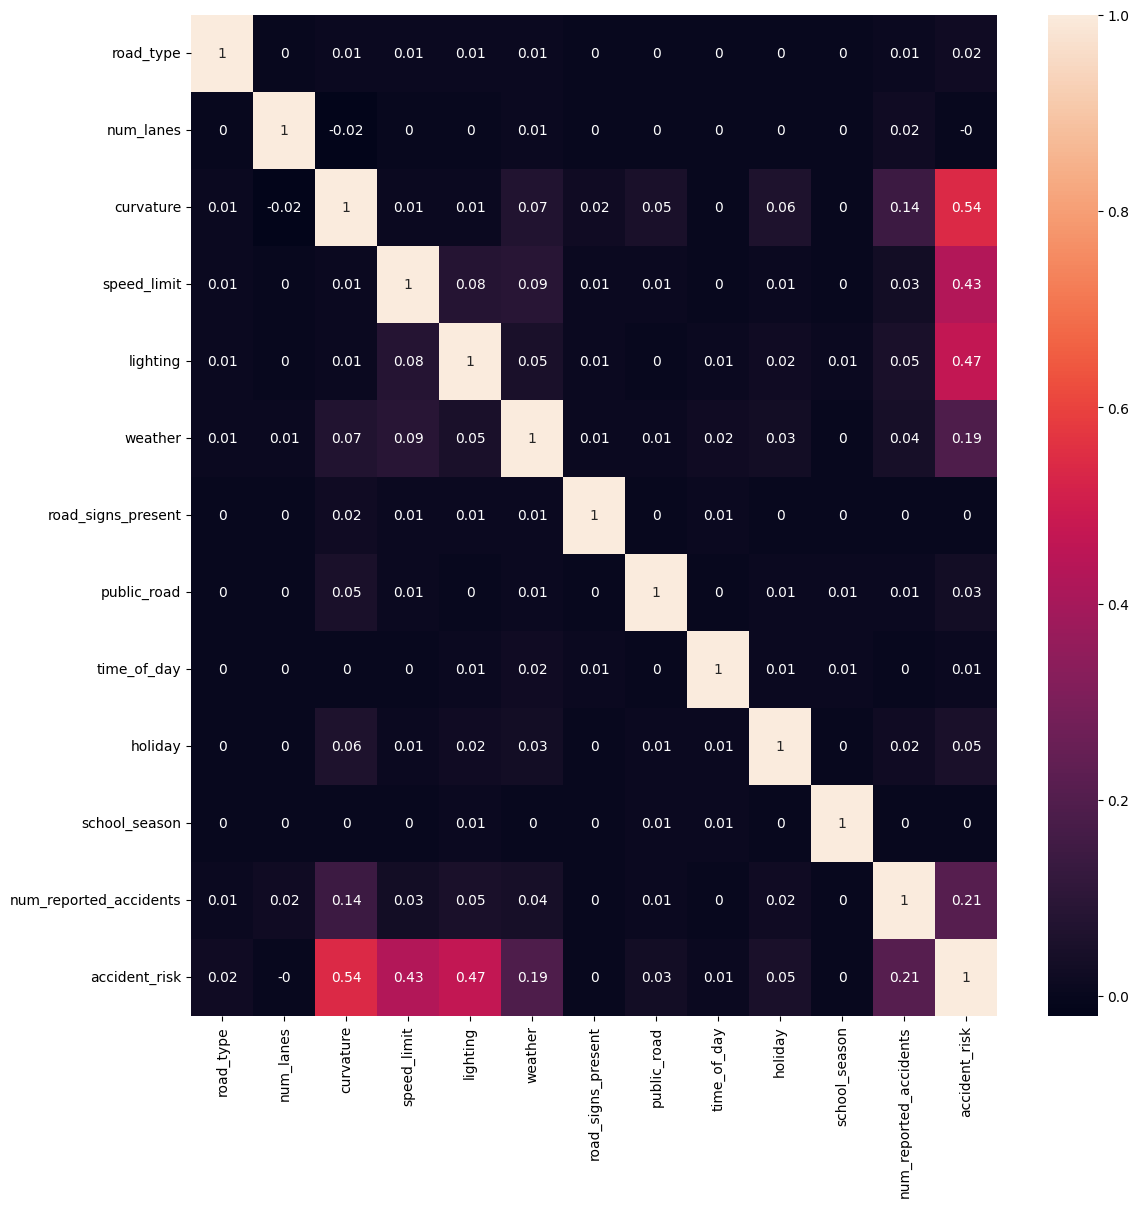

In [10]:
scores = score_maker(train)
plt.figure(figsize=(13, 13))
sns.heatmap(scores[scores.columns].astype(float).round(2), annot = True)

We see that there is not a lot of connection between the predictor variables, but we see a few variables which show a decent association with accident risk. <br>
We have to mind however, that the other effect sizes we used are not identical to the correlation coefficient, nor to each other, and mean mostly different things. The scales of them are also not perfectly identical so such a comparison as seen above is quite rough and has some shortcomings. <br>
However, the table is an easy overfew of where possible associations could be. <br>
We can further explore a few examples. Lets look at road type and the time of day.

In [11]:
pd.crosstab(train["road_type"], train["time_of_day"])

time_of_day,afternoon,evening,morning
road_type,,,
highway,34652,34648,35044
rural,34565,34551,34678
urban,33934,34439,34141


We see again there is no connection between the two variables, which is probably to be expected. <br>
We can also look at more meaningful connections, such as accident risk and speed limit.

<Axes: xlabel='speed_limit', ylabel='accident_risk'>

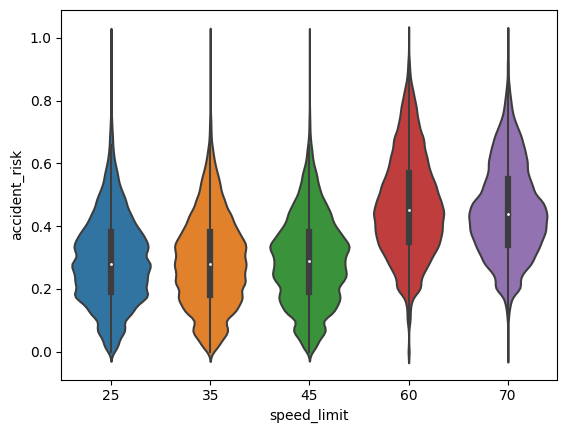

In [12]:
sns.violinplot(x = train["speed_limit"],y =train["accident_risk"])

We see a lower accident risk at speed limits of 25, 35, and 45 mph, but then a jump and higher accident risk at 60 and 70 mph. <br>
Now it is finally time to make some models and predictions. <br>
At first some thoughts about the task: <br>
The interesting thing about this task is that we want to predict the risk for an accident, which might suggest a classification task, however we have the probabilities (risk) given, instead of simply 0 and 1. The model should therefore reflect this. A linear regression is not useful, as it could predict values higher than 1 or lower than 0, and a logistic regression would not make use of all the information we have, as we would have to change the outcome to binary values. <br>
Tree-based models, such as a Random Forest could work, even in their regression form, as their predictions are mostly averages of learned values, meaning they should not exceed 0 at the lower end or 1 at the higher end. <br>

### Predicting Accident Risk

Given that we have many categorical data, CatBoost is an obvious model-choice, as this is well equiped to deal with categorical data. This makes it easy for us, because we don't have to think about encoding. It is also tree-based, so it should stay in the relevant boundaries of the prediction task. However, the model does not "know" that it is predicting probabilities, in this case, it only works as a regressor. <br>
At first we tune the model to find the best hyperparameters. For this, I used a randomized search, but I commented this cell out, so the notebook runs faster. I have displayed the best hyperparameters below.

In [13]:
from catboost import CatBoostRegressor

#parameters = {'iterations': [int(x) for x in np.logspace(np.log10(100),np.log10(2000), num = 15)],
#             'learning_rate': [x for x in np.logspace(np.log10(0.1), np.log10(0.9), num = 10)],
#             'depth': [4,6,8,10,12],
#             'l2_leaf_reg': [x for x in np.logspace(np.log10(100),np.log10(2000), num = 15)],
#             'colsample_bylevel': [x for x in np.logspace(np.log10(0.1), np.log10(0.9), num = 10)]}
#cat_reg = CatBoostRegressor(loss_function = "RMSE", cat_features = object_cols, verbose = 0,
#                            early_stopping_rounds = 50, random_state = 13)
#randomized_search_results = cat_reg.randomized_search(param_distributions = parameters, X = train.drop("accident_risk", axis = 1), 
#                                                      y = train["accident_risk"], n_iter = 20, cv = 3)

#randomized_search_results["params"]

The best parameters were: depth = 6, learning_rate = 0.9, l2_leaf_reg = 686.0826, iterations = 1303. <br>
Now lets test the model on our validationset.

In [14]:
cat_model = CatBoostRegressor(loss_function = "RMSE", cat_features = object_cols, verbose = 0,
                             depth = 6, learning_rate = 0.9, l2_leaf_reg = 686.0826, iterations = 1303,
                              early_stopping_rounds = 50, random_state = 13)
cat_model.fit(X = train.drop("accident_risk", axis = 1), y = train["accident_risk"])
val_predictions = cat_model.predict(val.drop("accident_risk", axis = 1))
print("The test predictions range from {} to {}.".format(min(val_predictions), max(val_predictions)))
rmse = np.sqrt(mean_squared_error(val["accident_risk"], val_predictions))
print("Estimated RMSE: {}".format(round(rmse,4)))

The test predictions range from 0.012528955760268523 to 0.887073692851505.
Estimated RMSE: 0.0562


Our Predictions are in the range from 0 to 1, which is good, and our estimated RMSE also seems good. <br>

### Finding Important Variables

To make use of our model, we also want to find out which variables are important for the model and (hopefully) are predictive of accident risk 

<Axes: xlabel='Mean'>

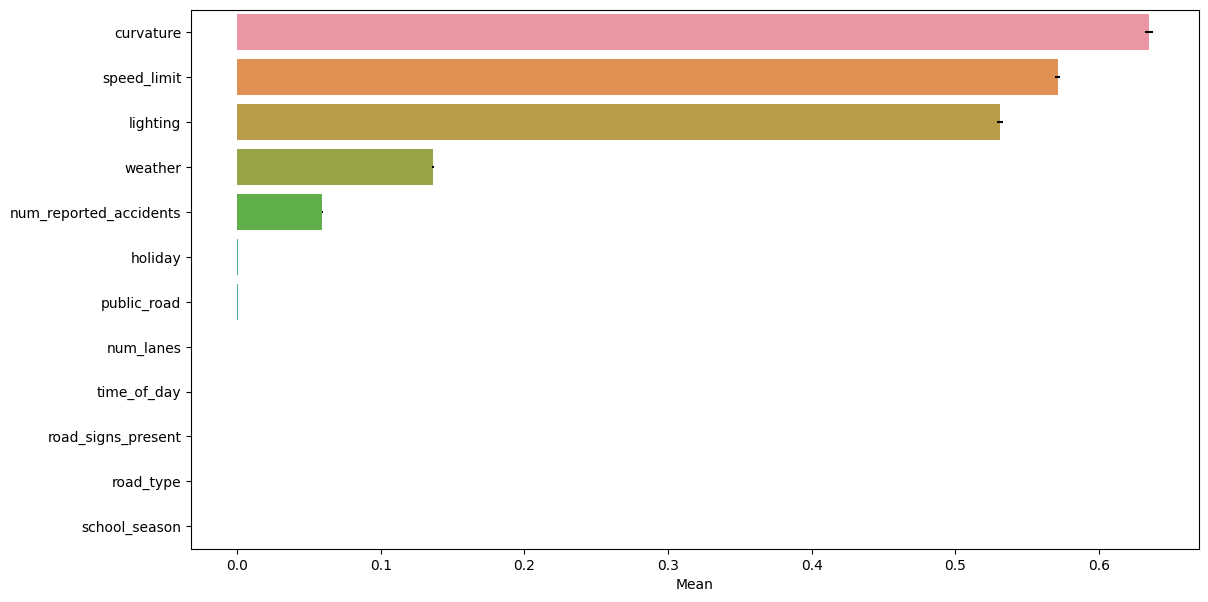

In [15]:
from sklearn.inspection import permutation_importance
r = permutation_importance(cat_model, val.drop("accident_risk", axis = 1), val["accident_risk"],
                           n_repeats=30,
                           random_state=13)

imp = pd.DataFrame({"Mean": r["importances_mean"], "std": r ["importances_std"]}, 
                   index = val.drop("accident_risk", axis = 1).columns)
imp = imp.sort_values(by = ["Mean"], ascending = False)
plt.figure(figsize=(13,7))
sns.barplot(y = imp.index,x = imp["Mean"], 
           xerr = imp["std"])

We see that the most important variable for our model and our predictions are the curvature, the speed limit, and lightning. Weather and the number of reported accidents also have some importance, the other variables do not seem important. We can also examine the importance using SHAP values. Let's try it!

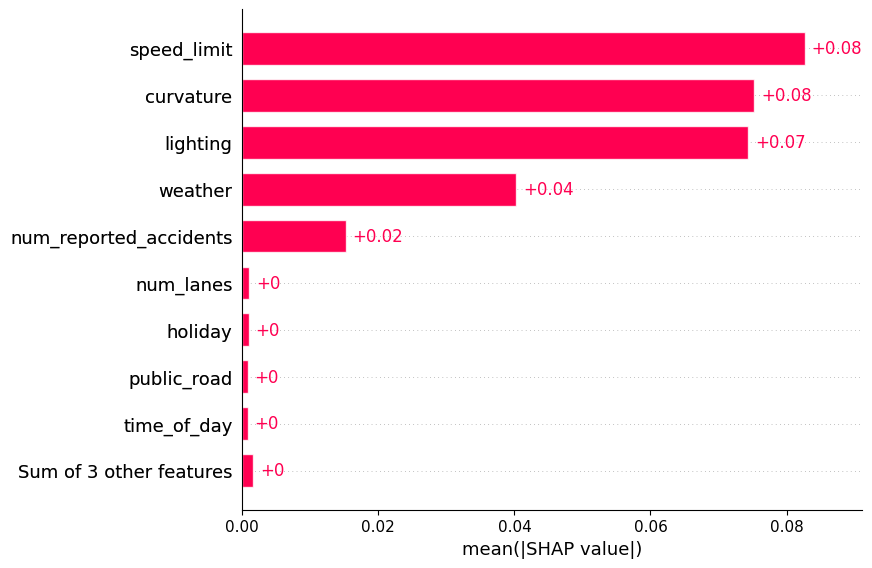

In [16]:
import shap
explainer = shap.Explainer(cat_model, random_state = 13)
shap_values = explainer(val.drop("accident_risk", axis = 1))
shap.plots.bar(shap_values)

The SHAP values are slightly different, but again the most important variables are the same, as well as the unimportant variables are still unimportant. <br>
In a real-world example, this insight could be used to make suggestions about how to mitigate risks for accidents. 

### Final notes.

For now, this will be the end of this notebook. There are however many more things which could be done and explored. Further steps could be...
- Feature Engineering: For example, whether there is a curvature and the speed limit is high might be even more important than the two features seperately, but also bad weather mixed with bad lightning might be especially risky. But we could also try to change our outcome variable, by transforming it.
- Excluding variables: As seen, some variables seem to be irrelevant for making predictions. We could try to exclude these, which might improve model-performance. (Sidenote: There are also reasons to keep those variables. Tree-based models often have their own method of excluding irrelevant variables when building a tree. But including noise variables (which do not hold any information) can work as a form of regularization and boost model performance)
- Trying different models: There are many different models we could use to predict the accident risk. We could also try to train a classifier instead of a regression model, which would make more use of the fact, that we predict a probability and do not have a regression model in the strict sense.
- Making use of the test set: I have split the data into three parts, the first two (train and validation), I use for building a model, examining it, playing around with different variables and models, and choosing a model. The test set is then finally used, to make an estimation on how well the model I have created will work. However, as I have only built one model and did not make any changes to the dataset (except encoding, which CatBoost did on its own), I have no reason to use the testset yet.

Anyway, thank you for reading my notebook, feel free to leave a comment, any ideas or feedback are highly anticipated.